<a href="https://colab.research.google.com/github/Rongxuan-Zhou/CS6120_project/blob/main/notebooks/4_hybrid_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 1. Environment Setup
!pip install -q rank_bm25 faiss-cpu sentence-transformers nltk
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import json
import torch
import time

PROJECT_PATH = "/content/drive/MyDrive/CS6120_project"
os.chdir(PROJECT_PATH)

# Memory monitoring
import psutil
print(f"Available memory: {psutil.virtual_memory().available/1024**3:.2f} GB")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available memory: 79.91 GB


In [9]:
# 2. Implement BM25Retriever
import re
from rank_bm25 import BM25Okapi

class BM25Retriever:
    def __init__(self, corpus):
        """初始化 BM25 检索器"""
        self.corpus = corpus
        print("Tokenizing corpus...")

        # 使用简单的分词方法，避免依赖 NLTK
        from tqdm import tqdm
        self.tokenized_corpus = []
        for doc in tqdm(corpus):
            # 简单分词：转小写，去除特殊字符，分割
            text = doc.lower()
            text = re.sub(r'[^a-z0-9\s]', '', text)
            tokens = [t for t in text.split() if len(t) > 2]
            self.tokenized_corpus.append(tokens)

        print("Building BM25 index...")
        self.bm25 = BM25Okapi(self.tokenized_corpus)

    def get_scores(self, query):
        """计算查询与所有文档的 BM25 分数"""
        # 简单分词处理查询
        query = query.lower()
        query = re.sub(r'[^a-z0-9\s]', '', query)
        tokenized_query = [t for t in query.split() if len(t) > 2]

        if not tokenized_query:  # 如果查询分词为空
            return np.zeros(len(self.corpus))
        return self.bm25.get_scores(tokenized_query)

    def retrieve(self, query, top_k=10):
        """检索 top-k 个结果"""
        scores = self.get_scores(query)
        top_indices = np.argsort(scores)[::-1][:top_k]

        results = []
        for idx in top_indices:
            results.append({
                "score": float(scores[idx]),
                "text": self.corpus[idx],
                "index": int(idx)
            })
        return results

In [10]:
# 3. Load corpus and create retrieval components
print("Loading corpus and models...")
# 加载语料库
with open("models/indexes/corpus_texts.json", "r") as f:
    corpus = json.load(f)
print(f"Loaded {len(corpus)} documents")

# 加载模型
print("Loading SBERT model...")
model = SentenceTransformer("models/sbert_model")
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# 加载索引
print("Loading FAISS index...")
index_hnsw = faiss.read_index("models/indexes/hnsw_index.faiss")  # 使用 HNSW 索引以获得更好的性能

# 创建 BM25 检索器
print("Initializing BM25 retriever...")
start_time = time.time()
bm25_retriever = BM25Retriever(corpus)
print(f"BM25 retriever initialization completed in {time.time() - start_time:.2f} seconds")

# 创建动态权重混合检索器
print("Initializing hybrid retriever...")
hybrid_retriever = DynamicWeighting(bm25_retriever, index_hnsw, model, corpus)
print("All components loaded successfully")

Loading corpus and models...
Loaded 11000 documents
Loading SBERT model...
Loading FAISS index...
Initializing BM25 retriever...
Tokenizing corpus...


100%|██████████| 11000/11000 [00:00<00:00, 48861.83it/s]


Building BM25 index...
BM25 retriever initialization completed in 0.46 seconds
Initializing hybrid retriever...
All components loaded successfully


In [11]:
# 4. Hybrid retrieval demo
test_queries = [
    "How does social media affect mental health?",
    "Best programming languages to learn",
    "Artificial intelligence applications",
    "Climate change solutions and mitigation strategies",
    "Nutrition advice for athletes performance"
]

for query in test_queries:
    print(f"\n{'='*40}\nQuery: {query}\n{'='*40}")

    # 分别获取 BM25 和向量检索结果
    print("\nBM25 Results:")
    bm25_results = bm25_retriever.retrieve(query, top_k=3)
    for i, result in enumerate(bm25_results):
        print(f"Result {i+1} (Score: {result['score']:.4f}):")
        print(f"{result['text'][:150]}...")

    print("\nVector Results:")
    vector_scores = hybrid_retriever.get_vector_scores(query, k=5)
    vector_top_indices = np.argsort(vector_scores)[::-1][:3]
    for i, idx in enumerate(vector_top_indices):
        print(f"Result {i+1} (Score: {vector_scores[idx]:.4f}):")
        print(f"{corpus[idx][:150]}...")

    # 获取混合检索结果
    print("\nHybrid Results:")
    hybrid_results = hybrid_retriever.retrieve(query, top_k=3)
    for i, result in enumerate(hybrid_results):
        print(f"Result {i+1} (Score: {result['score']:.4f}):")
        print(f"  BM25 Score: {result['bm25_score']:.4f}, Vector Score: {result['vector_score']:.4f}")
        print(f"{result['text'][:150]}...")

    print(f"\n{'='*40}\n")


Query: How does social media affect mental health?

BM25 Results:
Result 1 (Score: 21.3625):
health. As defined by World Health Organization (WHO), it is a State of complete physical, mental, and social well being, and not merely the absence o...
Result 2 (Score: 17.3306):
The Bureau of Labor Statistics reports that a BSW degree is required for most direct-service social work positions, though some may require an MSW. Th...
Result 3 (Score: 16.1901):
You'll usually need a referral from your GP or another doctor to see a psychiatrist on the NHS. Your GP may refer you directly to a psychiatrist or to...

Vector Results:
Result 1 (Score: 1.4724):
The prevention and treatment of medical and psychosomatic disorders and of undesired behaviors, such as biting the fingernails, by the application of ...
Result 2 (Score: 1.4526):
Back in March 2010, I wrote a post called Beware of “Who Viewed My Profile” Apps on Facebook. It’s still one of my top five viewed posts, with more th...
Result 3 (Sco

Analyzing query feature weights:
Short factual: 'What is climate change?' → BM25=0.58, Vector=0.42
Long factual: 'What are the main causes and effects of climate change in coastal regions during the last decade?' → BM25=0.50, Vector=0.50
Short semantic: 'Similar articles to health advice' → BM25=0.45, Vector=0.55
Long semantic: 'Find content related to the impact of technology on modern education systems' → BM25=0.42, Vector=0.58
Mixed short: 'Best diet tips' → BM25=0.55, Vector=0.45
Mixed long: 'Recommended strategies for improving mental health and reducing stress in workplace environments' → BM25=0.45, Vector=0.55


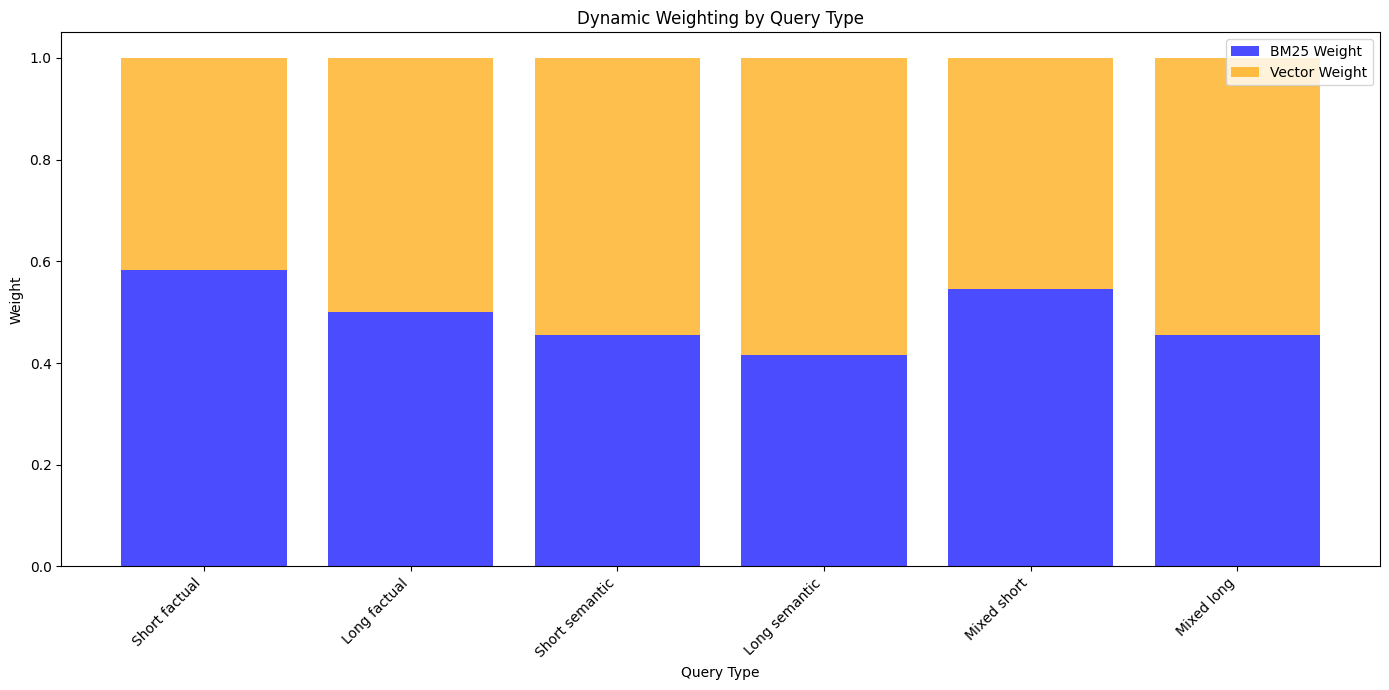

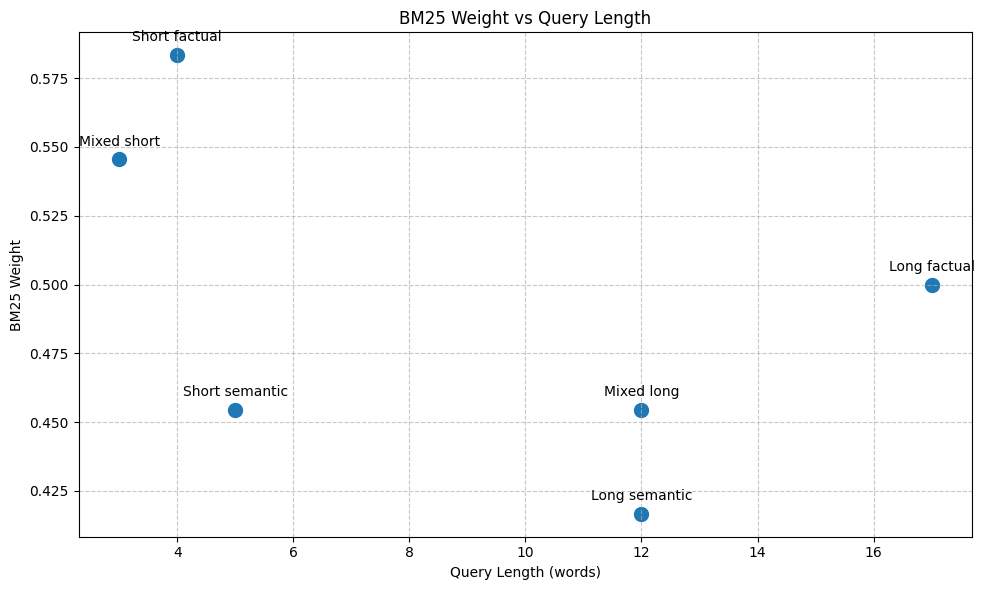

In [12]:
# 5. Weight analysis
import matplotlib.pyplot as plt

# 分析不同查询特征的权重
query_features = {
    "Short factual": "What is climate change?",
    "Long factual": "What are the main causes and effects of climate change in coastal regions during the last decade?",
    "Short semantic": "Similar articles to health advice",
    "Long semantic": "Find content related to the impact of technology on modern education systems",
    "Mixed short": "Best diet tips",
    "Mixed long": "Recommended strategies for improving mental health and reducing stress in workplace environments"
}

plt.figure(figsize=(14, 7))

# 权重分析
print("Analyzing query feature weights:")
for desc, query in query_features.items():
    bm25_w, vector_w = hybrid_retriever.calculate_weights(query)
    print(f"{desc}: '{query}' → BM25={bm25_w:.2f}, Vector={vector_w:.2f}")

    plt.bar(desc, bm25_w, label='BM25 Weight' if desc == "Short factual" else "", color='blue', alpha=0.7)
    plt.bar(desc, vector_w, bottom=bm25_w, label='Vector Weight' if desc == "Short factual" else "", color='orange', alpha=0.7)

plt.xlabel('Query Type')
plt.ylabel('Weight')
plt.title('Dynamic Weighting by Query Type')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 长度分析
lengths = [len(q.split()) for q in query_features.values()]
bm25_weights = [hybrid_retriever.calculate_weights(q)[0] for q in query_features.values()]

plt.figure(figsize=(10,6))
plt.scatter(lengths, bm25_weights, s=100)
for i, desc in enumerate(query_features.keys()):
    plt.annotate(desc, (lengths[i], bm25_weights[i]), textcoords="offset points",
                 xytext=(0,10), ha='center')

plt.xlabel('Query Length (words)')
plt.ylabel('BM25 Weight')
plt.title('BM25 Weight vs Query Length')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()